# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.561252,False,0.868333
1,2.176737,False,-0.588437
2,1.262491,True,7.390811
3,0.440620,True,5.850044
4,0.026995,True,5.388289
...,...,...,...
995,1.870740,True,6.276886
996,-0.691565,False,-0.142249
997,0.999085,True,4.128892
998,-0.452022,False,-0.846788


<Axes: xlabel='v0'>

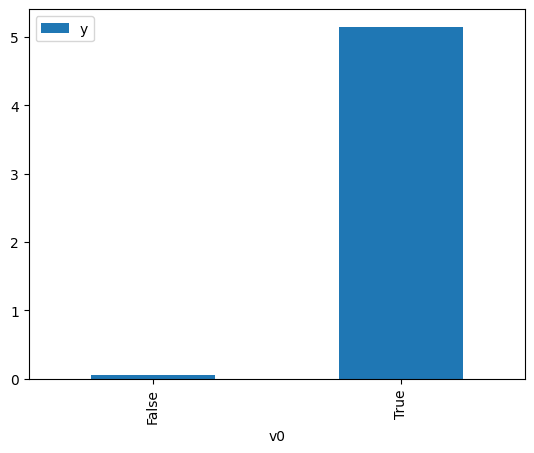

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

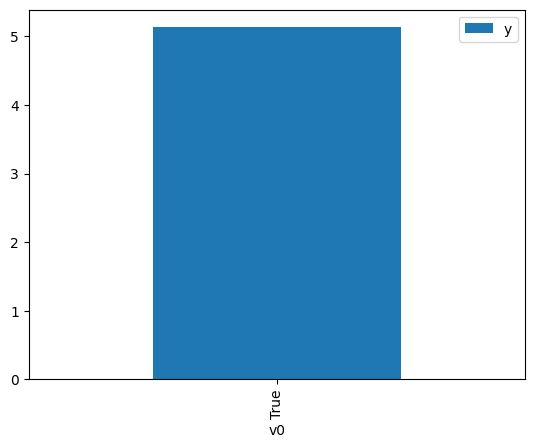

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.266352,False,-0.473516,0.372571,2.684052
1,0.818434,False,-0.479007,0.421609,2.371863
2,0.027323,False,0.790686,0.511488,1.955081
3,0.091353,False,-1.322200,0.504162,1.983488
4,-0.763380,False,0.593622,0.600585,1.665044
...,...,...,...,...,...
995,0.407241,False,-1.070387,0.468057,2.136493
996,2.352330,False,-1.994696,0.265357,3.768502
997,-0.254352,False,-0.943168,0.543613,1.839545
998,-0.932167,False,-0.603214,0.618966,1.615597


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.097119,True,4.972809,0.496497,2.014109
1,1.058798,True,4.237084,0.604965,1.652988
2,3.388532,True,4.523841,0.816472,1.224782
3,1.061958,True,3.203886,0.605310,1.652045
4,2.509190,True,4.606014,0.748402,1.336180
...,...,...,...,...,...
995,0.481193,True,4.702493,0.540362,1.850612
996,0.929779,True,4.940884,0.590767,1.692714
997,3.236923,True,5.616910,0.805844,1.240935
998,0.648760,True,6.392635,0.559344,1.787807


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                              7434.
Date:                Thu, 02 Nov 2023   Prob (F-statistic):                        0.00
Time:                        20:14:35   Log-Likelihood:                         -1408.1
No. Observations:                1000   AIC:                                      2820.
Df Residuals:                     998   BIC:                                      2830.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1975      0.032      6.144      0.000       0.134       0.261
x2             5.0341      0.048    104.304      0.000       4.939       5.129
==============================================================================
Omnibus:                        0.263   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.877   Jarque-Bera (JB):                0.345
Skew:                          -0.020   Prob(JB):                        0.841
Kurtosis:                       2.919   Cond. No.                         1.95
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""